In [1]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

import casadi as ca
from scipy.integrate import solve_ivp

import modeller, fitter

reloadlibs = [modeller, fitter]
for lib in reloadlibs:
    reload(lib)

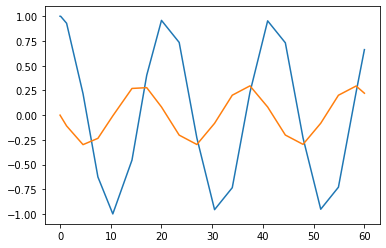

In [2]:
# pendulum system
# d2th/dt2 + g/l*sin(th) = 0

def system(t, y, p):
    return [
        y[1],
        -p[0]*np.sin(y[0])
    ]

p_true = [1/9.81]
# integrate forward
sol = solve_ivp(lambda t, y: system(t, y, p_true), [0, 60], [1, 0], dense_output=True)
plt.plot(sol.t, sol.y.T)

In [3]:
t_sample = np.linspace(0, 60, 15)
data_sample = sol.sol(t_sample).T
data_sample[7] = None

config = {
    "grid_size": 100,
    "basis_number": 50,
    "model_form": {
        "state": 2,
        "parameters": 1
    },
    "time_span": [0, 60],
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_sample, "t": t_sample},
    "observation_vector": [0, 1],
    "weightings":[
        [1]*1, # num params
        [1]*len(t_sample)
    ],
    "regularisation_value": [0],
}

In [4]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha])
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [5]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getdx = ca.Function('getdx', [solver_setup['x']], [model.xdash])
getc = ca.Function('getc', [solver_setup['x']], model.cs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
f_ex = ca.Function('f_ex', [solver_setup['x'], objective.rho, objective.alpha], [objective.objective])

In [6]:
p0 = [0]
c0 = np.ones(config['basis_number']*config['model_form']['state'])
x0 = np.hstack([*c0, p0])

In [7]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-5]))
    xguess = np.array(solutions[-1]['x']).flatten()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5151

Total number of variables............................:      101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.9117217e-08 0.00e+00 1.32e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.8952357e-08 0.00e+00 1.14e-10  -8.6 6.36e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   6.8952357362973158e-08    6.8952357362973158e-08
Dual infeasibility......:   1.1410708074748006e-10    1.1410708074748006e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.1410708074748006e-10    1.1410708074748006e-10


Number of objective function evaluations             = 2
Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6210629e-07 0.00e+00 6.27e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6169720e-07 0.00e+00 3.48e-10  -8.6 1.89e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   2.6169720034369725e-07    2.6169720034369725e-07
Dual infeasibility......:   3.4771077778914639e-10    3.4771077778914639e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.4771077778914639e-10    3.4771077778914639e-10


Number of objective function evaluations             = 2
Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3161496e-07 0.00e+00 1.11e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.3154740e-07 0.00e+00 4.92e-11  -8.6 1.78e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   4.3154740401333550e-07    4.3154740401333550e-07
Dual infeasibility......:   4.9158343596182098e-11    4.9158343596182098e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.9158343596182098e-11    4.9158343596182098e-11


Number of objective function evaluations             = 2
Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7544552e-07 0.00e+00 1.51e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.7543859e-07 0.00e+00 4.88e-12  -8.6 1.34e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   5.7543858542123089e-07    5.7543858542123089e-07
Dual infeasibility......:   4.8786316020945622e-12    4.8786316020945622e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.8786316020945622e-12    4.8786316020945622e-12


Number of objective function evaluations             = 2
Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  83.00us ( 41.50us)  83.75us ( 41.87us)         2
    nlp_grad  | 105.00us (105.00us) 104.58us (104.58us)         1
  nlp_grad_f  | 312.00us (104.00us) 311.76us (103.92us)         3
  nlp_hess_l  |   5.98ms (  5.98ms)   5.98ms (  5.98ms)         1
       total  |   9.15ms (  9.15ms)   8.81ms (  8.81ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0

Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.5039238919761552e-09    4.5039238919761552e-09


Number of objective function evaluations             = 2
Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  95.00us ( 47.50us)  94.81us ( 47.41us)         2
    nlp_grad  | 110.00us (110.00us) 109.86us (109.86us)         1
  nlp_grad_f  | 319.00us (106.33us) 318.92us (106.31us)         3
  nlp_hess_l  |   

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9398313e-05 0.00e+00 4.15e-05  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.9379255e-05 0.00e+00 2.12e-07  -5.7 1.91e-04    -  1.00e+00 1.00e+00f  1
   2  2.9379255e-05 0.00e+00 9.84e-15  -8.6 2.48e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:   2.9379255167314400e-05    2.9379255167314400e-05
Dual infeasibility......:   9.8356008938500078e-15    9.8356008938500078e-15
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   9.8356008938500078e-15    9.8356008938500078e-15


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 0
Number of inequal

   1  1.5422727e-04 0.00e+00 1.17e-06  -5.7 1.59e-04    -  1.00e+00 1.00e+00f  1
   2  1.5422727e-04 0.00e+00 1.21e-13  -8.6 2.99e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:   1.5422727418059451e-04    1.5422727418059451e-04
Dual infeasibility......:   1.2123525314623566e-13    1.2123525314623566e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.2123525314623566e-13    1.2123525314623566e-13


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0196341e-03 0.00e+00 1.40e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0194765e-03 0.00e+00 1.24e-04  -5.7 5.99e-04    -  1.00e+00 1.00e+00f  1
   2  1.0194765e-03 0.00e+00 1.09e-11  -5.7 1.44e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:   1.0194764895891488e-03    1.0194764895891488e-03
Dual infeasibility......:   1.0905363817656413e-11    1.0905363817656413e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.0905363817656413e-11    1.0905363817656413e-11


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 0
Number of inequal

   5  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 2.98e-08f 26
   6  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
   7  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
   8  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
   9  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
  11  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
  12  4.5165365e-03 0.00e+00 1.03e-08  -9.0 7.16e-10    -  1.00e+00 1.49e-08f 27
  13  4.5165365e-03 0.00e+00 3.37e-12  -9.0 7.16e-10    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   4.5165364553575492e-03    4.5165364553575492e-03
Dual infeas

   4  8.7076246e-03 0.00e+00 1.07e-07  -8.6 1.17e-08    -  1.00e+00 5.00e-01f  2
   5  8.7076246e-03 0.00e+00 5.34e-08  -8.6 5.86e-09    -  1.00e+00 5.00e-01f  2
   6  8.7076246e-03 0.00e+00 2.67e-08  -8.6 2.93e-09    -  1.00e+00 5.00e-01f  2
   7  8.7076246e-03 0.00e+00 1.22e-11  -8.6 1.46e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   8.7076246097951698e-03    8.7076246097951698e-03
Dual infeasibility......:   1.2178228044057438e-11    1.2178228044057438e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.2178228044057438e-11    1.2178228044057438e-11


Number of objective function evaluations             = 28
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequa

True [0.1019367991845056] Recovered 0.102017


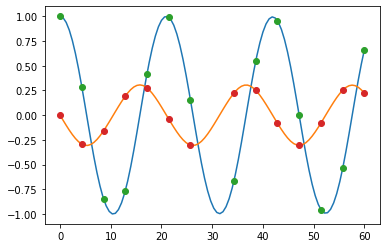

In [14]:
idx = 80
for y in getx(solutions[idx]['x']):
    plt.plot(model.observation_times, y)
plt.plot(t_sample, data_sample, 'o')
print("True", p_true, "Recovered", getp(solutions[idx]['x']))

In [10]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

Text(0, 0.5, 'Model Error')

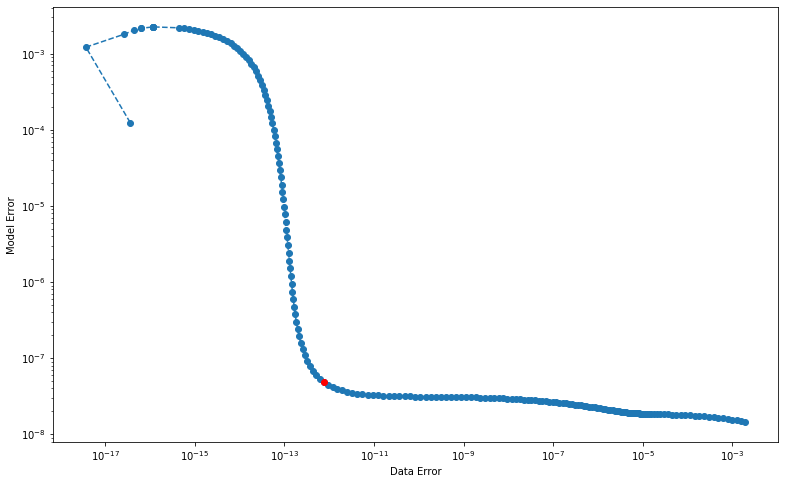

In [13]:
idx = 80
fig, ax=plt.subplots(figsize=[13, 8])
ax.loglog(*fsvals.T, 'o--')
ax.loglog(*fsvals[idx], 'ro')
ax.set_xlabel("Data Error")
ax.set_ylabel("Model Error")